## Sentiment Analysis of Ethiopia Reviews with Topic Modelling

The following pipeline will show a step-by-step approach of our project methodology. The explanations for the code can be seen in markdown below the code snippets they are respectively referring to.
<br>
<br>Notes:<br>
<ul>
    <li>Only English Reviews were scraped from TripAdvisor</li>
    <li>Only three (3) Destination Types were used in this methodology</li>
    <li>The other notebooks from the other folders are either fragments of this main pipeline or iterations that did not produce promising results</li>
</ul>

<h2>Table of Contents</h2>

<div class="alert alert-block alert-info" style="margin-top: 20px">
<ul>
    <li><a href="#importing_modules">Importing Modules</a></li>
    <li><a href="#web_scraping">Web Scraping</a></li>
    <ul>
        <li><a href="#web_scraping1">Getting all Initial Review Pages from all wanted Tourist Destinations</a></li>
        <li><a href="#web_scraping2">Getting All Review Pages from Initial Pages</a></li>
        <li><a href="#web_scraping3">Getting all Reviews from all Review Pages</a></li>
    </ul>
    <li><a href="#data_preprocessing">Data Preprocessing</a></li>
    <ul>
        <li><a href="#data_preprocessing1">Data Cleaning</a></li>
        <li><a href="#data_preprocessing2">Feature Engineering</a></li>
    </ul>
    <li><a href="#conclusion">Topic Modelling</a></li>
</ul>
    
</div>
 
<hr>

<a id='importing_modules'></a>
### Importing Modules

In [1]:
import requests
from bs4 import BeautifulSoup
import time
import random
import re
import collections

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim  

import spacy
from spacy.lemmatizer import Lemmatizer
from spacy.lang.en.stop_words import STOP_WORDS
from textblob import TextBlob
import nltk
from nltk import tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords

import os
from tqdm import tqdm_notebook as tqdm
from pprint import pprint
import warnings
warnings.filterwarnings('ignore')

headers = requests.utils.default_headers()
headers.update({
    'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:52.0) Gecko/20100101 Firefox/52.0',
})

C:\Users\HP\Anaconda3\lib\site-packages\nltk\decorators.py:68: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  regargs, varargs, varkwargs, defaults, formatvalue=lambda value: ""
C:\Users\HP\Anaconda3\lib\site-packages\nltk\lm\counter.py:15: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence, defaultdict


<a id='web_scraping'></a>
### Web Scraping

<a id='web_scraping1'></a>
**Getting all Initial Review Pages from all wanted Tourist Destinations**

In [ ]:
# Three Main Destination Types:
# Sights and Landmarks
# Nature and Parks
# Museums
site_category_list = ['https://www.tripadvisor.com.ph/Attractions-g293790-Activities-c47-t2,3,10,15,17,19,26,76,163,175-Ethiopia.html', # Sights and Landmarks
                    'https://www.tripadvisor.com.ph/Attractions-g293790-Activities-c57-t57,66,67,68,70-Ethiopia.html', # Nature and Parks
                     'https://www.tripadvisor.com.ph/Attractions-g293790-Activities-c49-t1,28,29,30,161-Ethiopia.html'] # Museums
skipped_urls = []
first_page_list = []

The above list of URLs encompasses all the tourist destinations of interest. This, of course, can easily be modified just in case you want to scrape destinations from different countries, destination types, etc. 

In [ ]:
def getFirstPages(x):
    for i in x:
        page = requests.get(i)
        soup = BeautifulSoup(page.content, 'html.parser')
        sites = soup.find_all(class_ = 'attraction_element')
        for j in sites:
            if j.find(class_ = 'rs rating') != None:
                first_page_list.append('https://www.tripadvisor.com.ph/' + j.find(class_ = 'listing_title').a.get('href'))
        if len(sites) == 0 and i not in skipped_urls:
            skipped_urls.append(i)
        if len(sites) > 0 and i in skipped_urls:
            skipped_urls.remove(i)
        print('skipped: ', skipped_urls)
        time.sleep(random.uniform(15, 30))
    if len(skipped_urls) != 0:
        print('restarting function...')
        getFirstPages(skipped_urls)

The above code will iterate over all the destinations present within the _site_category_list_ URLs and get their respective href attributes to get all the first review pages of the destinations. Since sometimes requests from Beautiful Soup fail to get data from the web page, the function is recursive so that in the case that URLs are skipped, they will be fed again to the function. This feature will be present in future scraping code as well.

In [ ]:
getFirstPages(site_category_list)

Getting all first pages

In [ ]:
final_first_page_list = []
for i in range(len(first_page_list)):
    final_first_page_list.append(first_page_list[i][0:30] + first_page_list[i][31:])

The above code removes the double slash after "tripadvisor.com.ph"

<a id='web_scraping2'></a>
**Getting All Review Pages from Initial Pages**

In [ ]:
final_url_list = []
skipped_urls = []

In [ ]:
def getFinalList(x):
    for i in x:
        page_nos = []
        print('site: ', i)
        page = requests.get(i, headers = headers)
        soup = BeautifulSoup(page.content, 'html.parser')
        readcheck = soup.find_all(class_ = 'count')
        print('readcheck: ', len(readcheck))
        for j in soup.find_all('a'):
            if j.get('data-page-number') != None and readcheck != 0:
                page_nos.append(j.get('data-page-number'))
            elif j.get('data-page-number') == None and readcheck != 0:
                page_nos.append(0)
        if len(readcheck) == 0:
            page_nos = []
        page_nos = list(map(int, page_nos))
        if len(page_nos) > 0:
            final_url_list.append(i)
            if max(page_nos) > 0:
                getReviewPages(i, max(page_nos))
        if len(page_nos) == 0 and i not in skipped_urls:
            skipped_urls.append(i)
        if len(page_nos) > 0 and i in skipped_urls:
            skipped_urls.remove(i)
        print('skipped: ', skipped_urls)
        time.sleep(random.uniform(15, 30))
    if len(skipped_urls) != 0:
        print('restarting function...')
        getFinalList(skipped_urls)
        
def getReviewPages(x, y):
    pre = re.findall('https://www.tripadvisor.com.ph/Attraction_Review-\w\d+-\w\d+-Reviews-' , x)
    post = re.findall('Reviews-\D+' , x)
    print(len(pre))
    print(len(post))
    review_pages = ((pre[0] + 'or{}' + post[0].replace('Reviews', '')).format(j) for j in range(10, y*10, 10))
    final_url_list.extend(review_pages)

The above code iterates over all first review pages acquired earlier, checks for the respective number of pages for each destination, and returns all the URLs needed for the main data scraping sequence later. Regular Expressions were used to properly construct subsequent URLs as they follow a pattern after the first pages. Again, it is recursive in nature to take into consideration the skipped URLs.

In [ ]:
getFinalList(final_first_page_list)

Getting all URLs of Reviews

In [ ]:
final_url_list = list(set(final_url_list)) # All needed URLs to be scraped (no duplicates)

Removing all duplicates just in case

<a id='web_scraping3'></a>
**Getting all Reviews from all Review Pages**

In [ ]:
rev_place_list = []
rev_head_list = []
rev_body_list = []
rev_rating_list = []
rev_date_list = []
skipped_urls = []
ignored_urls = []

In [ ]:
def getPlace(x, y):
    for i in y.find_all(class_ = 'noQuotes'):
        rev_place_list.append(x.find(id = 'HEADING').string)

def getHead(x):
    for i in x.find_all(class_ = 'noQuotes'):
        rev_head_list.append(i.string)

def getBody(x):
    z = x.find_all(class_ = 'entry')
    for i in z:
        if i.find(class_ = 'taLnk ulBlueLinks') != None:
            rev_body_list.append(i.text[:-4])
        else:
            rev_body_list.append(i.text)

def getRating(x):
    rev_revs = x.find_all(class_='ui_column is-9')
    for i in range(len(rev_revs)):
        if rev_revs[i].find(class_ = 'ui_bubble_rating bubble_50') != None:
            rev_rating_list.append(5)
        elif rev_revs[i].find(class_ = 'ui_bubble_rating bubble_40') != None:
            rev_rating_list.append(4)
        elif rev_revs[i].find(class_ = 'ui_bubble_rating bubble_30') != None:
            rev_rating_list.append(3)
        elif rev_revs[i].find(class_ = 'ui_bubble_rating bubble_20') != None:
            rev_rating_list.append(2)
        elif rev_revs[i].find(class_ = 'ui_bubble_rating bubble_10') != None:
            rev_rating_list.append(1)

def getDate(x):
    for i in x.find_all(class_ = 'prw_rup prw_reviews_stay_date_hsx'):
        if i.find(class_ = 'stay_date_label') == None:
            rev_date_list.append('None')
        else:
            rev_date_list.append(str(i.span.next_sibling).strip())

def delay(x, y):
    time.sleep(random.uniform(x, y))
    return None

def getData(urls):
    start_revs_head = 0
    end_revs_head = 0
    start_revs_body = 0
    end_revs_body = 0
    for i in urls:
        start_revs_head = len(rev_head_list)
        start_revs_body = len(rev_body_list)
        print('start head: ', len(rev_head_list), 'start body: ', len(rev_body_list))
        page = requests.get(i, headers = headers)
        soup = BeautifulSoup(page.content, 'html.parser')
        rev = soup.find(id = 'REVIEWS')
        getHead(rev)
        getBody(rev)
        end_revs_head = len(rev_head_list)
        end_revs_body = len(rev_body_list)
        print('end head: ', len(rev_head_list), 'end body: ', len(rev_body_list))
        if len(rev_head_list) != len(rev_body_list):
            print('ignoring url...')
            ignored_urls.append(i)
            del rev_head_list[- (end_revs_head - start_revs_head):]
            del rev_body_list[- (end_revs_body - start_revs_body):]
            continue
        if end_revs_head == start_revs_head and i not in skipped_urls:
            skipped_urls.append(i)
        if end_revs_head > start_revs_head and i in skipped_urls:
            skipped_urls.remove(i)
        print('skipped URL count: ', len(skipped_urls))
        getPlace(soup, rev)
        getRating(rev)
        getDate(rev)
        delay(5, 15)
    if len(skipped_urls) != 0:
        print('restarting function...')
        getData(skipped_urls)

The above code iterates over all of the review page URLs and gets the review data from each page. The  five (5) following features were the main data of interest:
<ul>
    <li>Destination Name</li>
    <li>Review Head</li>
    <li>Review Body</li>
    <li>Rating</li>
    <li>Date of Experience</li>
</ul>
<br>Again, it is recursive in nature to take into consideration the skipped URLs. Also, there are instances where some people would reply to a review and should this happen in a review page URL, the code ignores the URL since it will treat the reply as a review body and it will cause a mismatch between the counts of review heads and review bodies. Not much data is lost in this case as, if I recall correctly, there were only three (3) ignored URLs that showed reviews with replies.

In [ ]:
getData(final_url_list)

Getting all the needed data

In [ ]:
print(len(rev_place_list))
print(len(rev_head_list))
print(len(rev_body_list))
print(len(rev_rating_list))
print(len(rev_date_list))

Checking if the counts for all five (5) features match (they should)

<a id='data_preprocessing'></a>
### Data Preprocessing

<a id='data_preprocessing1'></a>
**Data Cleaning**

In [ ]:
df1 = pd.DataFrame({'Destination Name': rev_place_list, 'Review Head': rev_head_list, 'Review Body': rev_body_list, 'Rating': rev_rating_list, 'Date': rev_date_list})
df1 = df1.drop_duplicates()
df1['Destination Name'] = df1['Destination Name'].replace(to_replace = 'Chebera-Churchura National Park', 
                                                               value = 'Chebera Churchura National Park')
df1.head()

The above code creates a dataframe from the five (5) lists acquired earlier via scraping. It also drops duplicates.
There were instances of the destination "Chebera Churchura National Park" with an extra hyphen so they were replaced accordingly for the sake of formality.

In [ ]:
landmarks = ['Monastery of Debre Damo'] # this site was removed from the initial URLs for some reason since our first scraping 
nature_parks = []
museums = []

def getDestinationsByType(x):
    for i in range(len(x)):
        page = requests.get(x[i])
        soup = BeautifulSoup(page.content, 'html.parser')
        sites = soup.find_all(class_ = 'attraction_element')
        for j in sites:
            k = j.find(class_ = 'listing_title').text
            k = re.sub("^\s+", "", k)
            k = re.sub("\s+$", "", k)
            k = re.sub("\s+.+$", "", k)
            if i == 0:
                landmarks.append(k)
            elif i == 1:
                nature_parks.append(k)
            elif i == 2:
                museums.append(k)
        time.sleep(random.uniform(5, 10))

The above code iterates over all the destinations from the initial _site_category_list_ URLs and filters them accordingly into lists of the three destination types.

In [ ]:
getDestinationsByType(site_category_list)

Filling up the lists - _landmarks_ + _nature_parks_ + _museums_ 

In [ ]:
def destinationType(row):
    if row['Destination Name'] in landmarks:
        return 'Landmarks'
    elif row['Destination Name'] in nature_parks:
        return 'Nature/Parks'
    elif row['Destination Name'] in museums:
        return 'Museums'
    
df1['Destination Type'] = df1.apply(destinationType, axis = 1)
df1.head() # df1 is now the first main checkpoint dataframe gotten from scraping

The above code creates the _Destination Type_ feature and iterates over all the _Destination Names_ to classify them.
<br>df1 is now the main checkpoint dataframe that is already ready for different use cases and subsequent changes are now based on the methodology to be applied.  

In [2]:
df2 = pd.read_csv('ethiopia_tripadvisor_data_1.csv') # df2 is the same as df1 (we just saved it before into a csv file)
df2.head()

,Destination Name,Destination Type,Rating,Review Head,Review Body,Date
0,Rock-Hewn Churches of Lalibela,Landmarks,5,Incredible locations don't be put off thinking...,Amazing location must visit. This site is mark...,October 2019
1,Rock-Hewn Churches of Lalibela,Landmarks,5,It is a real miracle of the world!,I do recommend to visit Lalibela churches and ...,October 2019
2,Rock-Hewn Churches of Lalibela,Landmarks,5,Incredible experience,A must visit in Ethiopia - one of the most uni...,October 2019
3,Rock-Hewn Churches of Lalibela,Landmarks,4,Amazing,These churches have to be seen to be believed....,October 2019
4,Rock-Hewn Churches of Lalibela,Landmarks,5,So much history,Thanks to our tour organiser Ephram who is bas...,October 2019


Since, we already scraped the data beforehand into a csv file, the above code will call it instead of re-running the web scraping pipeline above 
(of course, you are open to make scraping modifications above depending on your possible future use case).   

In [3]:
df2 = df2.mask(df2.eq('None')).dropna()
df2 = df2.drop(['Rating', 'Date'], axis = 1)
df2.head()

,Destination Name,Destination Type,Review Head,Review Body
0,Rock-Hewn Churches of Lalibela,Landmarks,Incredible locations don't be put off thinking...,Amazing location must visit. This site is mark...
1,Rock-Hewn Churches of Lalibela,Landmarks,It is a real miracle of the world!,I do recommend to visit Lalibela churches and ...
2,Rock-Hewn Churches of Lalibela,Landmarks,Incredible experience,A must visit in Ethiopia - one of the most uni...
3,Rock-Hewn Churches of Lalibela,Landmarks,Amazing,These churches have to be seen to be believed....
4,Rock-Hewn Churches of Lalibela,Landmarks,So much history,Thanks to our tour organiser Ephram who is bas...


The above code removes the _Rating_ and _Date_ features since they are not part of the methodology in this pipeline. They are, however, used in the other notebooks for Exploratory Data Analysis.

In [4]:
df2 = df2.drop_duplicates()
print(df2.duplicated().sum())
print(df2.isnull().sum())
print(df2.isna().sum())

0
Destination Name    0
Destination Type    0
Review Head         0
Review Body         0
dtype: int64
Destination Name    0
Destination Type    0
Review Head         0
Review Body         0
dtype: int64


In [5]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8310 entries, 0 to 8412
Data columns (total 4 columns):
Destination Name    8310 non-null object
Destination Type    8310 non-null object
Review Head         8310 non-null object
Review Body         8310 non-null object
dtypes: object(4)
memory usage: 324.6+ KB


<a id='data_preprocessing2'></a>
**Feature Engineering**

In [6]:
df2['Review Text'] = df2['Review Head'] + ' ' + df2['Review Body'] # Review Text = Review Head + Review Body
df2['RB_Sentence1'] = df2['Review Body'].apply(lambda x: tokenize.sent_tokenize(x)[0]) # RB_Sentence 1 = Review Body Sentence 1
df2['Review Head'] = df2['Review Head'].apply(lambda x: re.sub('\s+', ' ', x))
df2['Review Body'] = df2['Review Body'].apply(lambda x: re.sub('\s+', ' ', x))
df2['Review Text'] = df2['Review Text'].apply(lambda x: re.sub('\s+', ' ', x))
df2['RB_Sentence1'] = df2['RB_Sentence1'].apply(lambda x: re.sub('\s+', ' ', x))
df2.head()

,Destination Name,Destination Type,Review Head,Review Body,Review Text,RB_Sentence1
0,Rock-Hewn Churches of Lalibela,Landmarks,Incredible locations don't be put off thinking...,Amazing location must visit. This site is mark...,Incredible locations don't be put off thinking...,Amazing location must visit.
1,Rock-Hewn Churches of Lalibela,Landmarks,It is a real miracle of the world!,I do recommend to visit Lalibela churches and ...,It is a real miracle of the world! I do recomm...,I do recommend to visit Lalibela churches and ...
2,Rock-Hewn Churches of Lalibela,Landmarks,Incredible experience,A must visit in Ethiopia - one of the most uni...,Incredible experience A must visit in Ethiopia...,A must visit in Ethiopia - one of the most uni...
3,Rock-Hewn Churches of Lalibela,Landmarks,Amazing,These churches have to be seen to be believed....,Amazing These churches have to be seen to be b...,These churches have to be seen to be believed.
4,Rock-Hewn Churches of Lalibela,Landmarks,So much history,Thanks to our tour organiser Ephram who is bas...,So much history Thanks to our tour organiser E...,Thanks to our tour organiser Ephram who is bas...


The above code creates the _Review Text_ and _RB_Sentence1_ feature where:
<li>Review Text = Review Head + Review Body</li>
<li>RB_Sentence 1 = Review Body Sentence 1</li>
<br>The Review Body Sentence 1 feature was made under the assumption that the main message of the tourist's review is based on the first sentence of the review body. What we found out as we progress towards Topic Modelling is that Review Head and Review Body Sentence 1 showed the best results both in the coherence score metric and the topics being more identifiable 

In [7]:
df2['TextBlob Polarity Head'] = df2['Review Head'].map(lambda text: TextBlob(text).sentiment.polarity)
df2['TextBlob Polarity Body'] = df2['Review Body'].map(lambda text: TextBlob(text).sentiment.polarity)
df2['TextBlob Polarity Text'] = df2['Review Text'].map(lambda text: TextBlob(text).sentiment.polarity)
df2['TextBlob Polarity RBS1'] = df2['RB_Sentence1'].map(lambda text: TextBlob(text).sentiment.polarity)
df2.head()

,Destination Name,Destination Type,Review Head,Review Body,Review Text,RB_Sentence1,TextBlob Polarity Head,TextBlob Polarity Body,TextBlob Polarity Text,TextBlob Polarity RBS1
0,Rock-Hewn Churches of Lalibela,Landmarks,Incredible locations don't be put off thinking...,Amazing location must visit. This site is mark...,Incredible locations don't be put off thinking...,Amazing location must visit.,-0.05,0.300000,0.125000,0.6000
1,Rock-Hewn Churches of Lalibela,Landmarks,It is a real miracle of the world!,I do recommend to visit Lalibela churches and ...,It is a real miracle of the world! I do recomm...,I do recommend to visit Lalibela churches and ...,0.25,-0.150000,-0.016667,0.0000
2,Rock-Hewn Churches of Lalibela,Landmarks,Incredible experience,A must visit in Ethiopia - one of the most uni...,Incredible experience A must visit in Ethiopia...,A must visit in Ethiopia - one of the most uni...,0.90,0.345000,0.483750,0.4375
3,Rock-Hewn Churches of Lalibela,Landmarks,Amazing,These churches have to be seen to be believed....,Amazing These churches have to be seen to be b...,These churches have to be seen to be believed.,0.60,0.225000,0.350000,0.0000
4,Rock-Hewn Churches of Lalibela,Landmarks,So much history,Thanks to our tour organiser Ephram who is bas...,So much history Thanks to our tour organiser E...,Thanks to our tour organiser Ephram who is bas...,0.20,0.233333,0.228571,0.2000


The above code assigns polarities for the different Review Text Types via TextBlob. We chose this instead of the Rating feature/metric since Rating
does a worse job in capturing sentiment (e.g. some reviews with high ratings have mixed sentiments within their reviews).
<br>More of this from here:
<li>https://econlife.com/2019/05/5-star-ratings-inflation/</li>
<li>https://datascience.stanford.edu/news/story-rated-five-stars-new-study-finds-online-ratings-systems-words-are-more-accurate-stars-and</li>

In [8]:
df2['RH_Split'] = df2['Review Head'].apply(lambda x: x.split(' '))
df2['RB_Split'] = df2['Review Body'].apply(lambda x: x.split(' '))
df2['RT_Split'] = df2['Review Text'].apply(lambda x: x.split(' '))
df2['RB_Sentence1_Split'] = df2['RB_Sentence1'].apply(lambda x: x.split(' '))
df2.head()

,Destination Name,Destination Type,Review Head,Review Body,Review Text,RB_Sentence1,TextBlob Polarity Head,TextBlob Polarity Body,TextBlob Polarity Text,TextBlob Polarity RBS1,RH_Split,RB_Split,RT_Split,RB_Sentence1_Split
0,Rock-Hewn Churches of Lalibela,Landmarks,Incredible locations don't be put off thinking...,Amazing location must visit. This site is mark...,Incredible locations don't be put off thinking...,Amazing location must visit.,-0.05,0.300000,0.125000,0.6000,"[Incredible, locations, don't, be, put, off, t...","[Amazing, location, must, visit., This, site, ...","[Incredible, locations, don't, be, put, off, t...","[Amazing, location, must, visit.]"
1,Rock-Hewn Churches of Lalibela,Landmarks,It is a real miracle of the world!,I do recommend to visit Lalibela churches and ...,It is a real miracle of the world! I do recomm...,I do recommend to visit Lalibela churches and ...,0.25,-0.150000,-0.016667,0.0000,"[It, is, a, real, miracle, of, the, world!]","[I, do, recommend, to, visit, Lalibela, church...","[It, is, a, real, miracle, of, the, world!, I,...","[I, do, recommend, to, visit, Lalibela, church..."
2,Rock-Hewn Churches of Lalibela,Landmarks,Incredible experience,A must visit in Ethiopia - one of the most uni...,Incredible experience A must visit in Ethiopia...,A must visit in Ethiopia - one of the most uni...,0.90,0.345000,0.483750,0.4375,"[Incredible, experience, ]","[A, must, visit, in, Ethiopia, -, one, of, the...","[Incredible, experience, A, must, visit, in, E...","[A, must, visit, in, Ethiopia, -, one, of, the..."
3,Rock-Hewn Churches of Lalibela,Landmarks,Amazing,These churches have to be seen to be believed....,Amazing These churches have to be seen to be b...,These churches have to be seen to be believed.,0.60,0.225000,0.350000,0.0000,[Amazing],"[These, churches, have, to, be, seen, to, be, ...","[Amazing, These, churches, have, to, be, seen,...","[These, churches, have, to, be, seen, to, be, ..."
4,Rock-Hewn Churches of Lalibela,Landmarks,So much history,Thanks to our tour organiser Ephram who is bas...,So much history Thanks to our tour organiser E...,Thanks to our tour organiser Ephram who is bas...,0.20,0.233333,0.228571,0.2000,"[So, much, history]","[Thanks, to, our, tour, organiser, Ephram, who...","[So, much, history, Thanks, to, our, tour, org...","[Thanks, to, our, tour, organiser, Ephram, who..."


The above code splits the different Review Text Types into lists of words as features. This will be helpful later when removing positive and negative words for the text preprocessing stage before topic modelling.

In [9]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8310 entries, 0 to 8412
Data columns (total 14 columns):
Destination Name          8310 non-null object
Destination Type          8310 non-null object
Review Head               8310 non-null object
Review Body               8310 non-null object
Review Text               8310 non-null object
RB_Sentence1              8310 non-null object
TextBlob Polarity Head    8310 non-null float64
TextBlob Polarity Body    8310 non-null float64
TextBlob Polarity Text    8310 non-null float64
TextBlob Polarity RBS1    8310 non-null float64
RH_Split                  8310 non-null object
RB_Split                  8310 non-null object
RT_Split                  8310 non-null object
RB_Sentence1_Split        8310 non-null object
dtypes: float64(4), object(10)
memory usage: 973.8+ KB


In [10]:
df2['Destination Type'].value_counts()

Landmarks       3803
Museums         2506
Nature/Parks    2001
Name: Destination Type, dtype: int64

<a id='topic_modelling'></a>
### Topic Modelling

Much of the following code is based on the topic modelling pipeline seen on the following site:
<br>https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#14computemodelperplexityandcoherencescore

In [11]:
test_subset = df2['RH_Split'].values
sid = SentimentIntensityAnalyzer()
pos_word_list=[]
neu_word_list=[]
neg_word_list=[]

for value in test_subset:
    for word in value:
        if (sid.polarity_scores(word)['compound']) >= 0.4:
            pos_word_list.append(word)
        elif (sid.polarity_scores(word)['compound']) <= -0.4:
            print
            neg_word_list.append(word)
        else:
            neu_word_list.append(word)                

print('Positive :', len(pos_word_list))
print('Neutral :', len(neu_word_list))
print('Negative :', len(neg_word_list))

Positive : 4117
Neutral : 35703
Negative : 326


The above code collects (and in the later parts, remove) positive and negative words with polarity scores above 0.4 and below -0.4 respectively . This is to avoid topics found later to be based solely upon positive and negative sentiments. This approach works since we will later preemptively filter positive and negative sentiments across the three (3) destination types.

In [12]:
main_stop_words = ['ethiopia', 'ethiopian', 'rock', 'hewn', 'church', 'churches', 'park', 'parks', 'museum', 
                       'museums', 'omo', 'valley', 'mountain', 'mountains', 'addis', 'ababa', 'lucy', 'simien', 
                       'national', 'lalibela', 'gelada', 'haile', 'selassie', 'gondar', 'africa' , 'harar', 
                       'cathedral', 'cathedrals', 'place', 'visit', 'girmay', 
                       '\n', '‘s']
positive_stop_words = list(set(pos_word_list))
negative_stop_words = list(set(neg_word_list))
total_stop_words = main_stop_words + positive_stop_words + negative_stop_words

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
stop_words.extend(total_stop_words)
print('Stop Words: ', len(stop_words))

Stop Words:  862


The above code initializes the Ethiopia stop words which are mostly composed of Named Entities that we do not want to show up in our topic key words since
they provide little value in our topic modelling analysis. These words along with the positive and negative stop words make up the total stop words to be used in the topic modelling pipeline.

In [13]:
# Convert to list
# data = df2[df2['Destination Type'] == 'Landmarks'][df2['TextBlob Polarity Head'] > 0]['Review Head'].values.tolist() # uncomment if needed
# data = df2[df2['Destination Type'] == 'Landmarks'][df2['TextBlob Polarity Head'] < 0]['Review Head'].values.tolist() # uncomment if needed
# data = df2[df2['Destination Type'] == 'Nature/Parks'][df2['TextBlob Polarity Head'] > 0]['Review Head'].values.tolist() # uncomment if needed
# data = df2[df2['Destination Type'] == 'Nature/Parks'][df2['TextBlob Polarity Head'] < 0]['Review Head'].values.tolist() # uncomment if needed
# data = df2[df2['Destination Type'] == 'Museums'][df2['TextBlob Polarity Head'] > 0]['Review Head'].values.tolist() # uncomment if needed
data = df2[df2['Destination Type'] == 'Museums'][df2['TextBlob Polarity Head'] < 0]['Review Head'].values.tolist()

# Remove emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['Sorry no - read the Bradt Guide']


The pipeline in this notebook can make use of the following six (6) LDA models:
<li>Landmarks, Positive Sentiments</li>
<li>Landmarks, Negative Sentiments</li>
<li>Nature/Parks, Positive Sentiments</li>
<li>Nature/Parks, Negative Sentiments</li>
<li>Museums, Positive Sentiments</li>
<li>Museums, Negative Sentiments</li>
<br> For this notebook, the LDA model to be used will concern the Negative Sentiments toward Museums. You are free to uncomment the data-to-list conversion code accordingly above for the other LDA models. Text from Review Head is used in this case as it is the best performer (only being slightly better than Review Body Sentence 1).

In [14]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc = True))  # deacc = True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['sorry', 'no', 'read', 'the', 'bradt', 'guide']]


Converting sentences to words while removing punctuations

In [15]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count = 5, threshold = 100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold = 100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['sorry', 'no', 'read', 'the', 'bradt', 'guide']


Building bigram and trigram models

In [16]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

Defining functions for the removal of stop words, bigram/trigram implementation, and lemmatization.

In [17]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable = ['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags = ['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['read']]


The "en_core_web_sm" model of the spaCy package may need to be installed via the terminal. If that is not possible, other english models such as "en" should also suffice. spaCy english models - https://spacy.io/models/en

In [18]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1)]]


Creating the Dictionary and Corpus to be used for the LDA Model

In [19]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('read', 1)]]

In [20]:
# Build LDA model (initial testing with number of topics = 10)
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

Running the LDA Model via gensim with 10 topics

In [21]:
# Print the key words in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.084*"go" + 0.071*"worth" + 0.067*"bit" + 0.059*"ancestor" + 0.055*"give" '
  '+ 0.044*"way" + 0.027*"eye" + 0.027*"insightful" + 0.023*"curate" + '
  '0.017*"confusing"'),
 (1,
  '0.146*"little" + 0.029*"closed" + 0.029*"lonely" + 0.015*"remembrance" + '
  '0.015*"deserve" + 0.015*"attention" + 0.015*"tale" + 0.015*"rate" + '
  '0.015*"underwhelme" + 0.015*"thing"'),
 (2,
  '0.155*"see" + 0.123*"much" + 0.100*"history" + 0.050*"learn" + '
  '0.050*"information" + 0.042*"else" + 0.026*"historical" + 0.021*"tough" + '
  '0.021*"emotionally" + 0.021*"heavy"'),
 (3,
  '0.107*"history" + 0.087*"dark" + 0.074*"informative" + 0.047*"chapter" + '
  '0.047*"gem" + 0.047*"recent" + 0.039*"important" + 0.032*"presentation" + '
  '0.021*"appropriate" + 0.021*"uncensored"'),
 (4,
  '0.075*"hide" + 0.059*"different" + 0.045*"close" + 0.034*"still" + '
  '0.029*"visit" + 0.029*"hour" + 0.029*"somewhat" + 0.029*"forget" + '
  '0.025*"reality" + 0.018*"story"'),
 (5,
  '0.189*"history" + 0.06

Printing the key words that make up the 10 acquired topics

In [22]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.625645760659661

Coherence Score:  0.5865694197868939


Computing the Perplexity (better if lower) and Coherence Score (range - 0 to 1, better if higher) of the LDA Model

In [23]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
os.environ.update({'MALLET_HOME':r'C:/Users/HP/mallet-2.0.8/'})
mallet_path = r'C:\Users\HP\mallet-2.0.8\bin\mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word, random_seed=1)

The above code implements the LDA Mallet Model of gensim which is generally seen as a better version of the raw LDA Model (more often shows better topics in terms of the coherence score metric and subjective identifiability)
<br>
<br>For this code, a zip file will need to be downloaded from the link given (http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip). the zip file in conjunction with the gensim package will enable the LDA Mallet Topic Model. The "mallet_path" indicates the location of the file in your local PC so adjust this accordingly with your corresponding file location.

In [24]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('history', 0.43333333333333335),
   ('difficult', 0.1),
   ('happen', 0.03333333333333333),
   ('derg', 0.03333333333333333),
   ('cover', 0.03333333333333333),
   ('secret', 0.03333333333333333),
   ('eye', 0.03333333333333333),
   ('visual', 0.03333333333333333),
   ('school', 0.03333333333333333),
   ('tale', 0.03333333333333333)]),
 (1,
  [('history', 0.21875),
   ('worth', 0.15625),
   ('presentation', 0.09375),
   ('tough', 0.0625),
   ('closed', 0.0625),
   ('surprisingly', 0.03125),
   ('unknown', 0.03125),
   ('gruesome', 0.03125),
   ('human', 0.03125),
   ('reflect', 0.03125)]),
 (2,
  [('information', 0.17391304347826086),
   ('informative', 0.15217391304347827),
   ('learn', 0.13043478260869565),
   ('chill', 0.08695652173913043),
   ('middle', 0.021739130434782608),
   ('chilling', 0.021739130434782608),
   ('history', 0.021739130434782608),
   ('communist', 0.021739130434782608),
   ('building', 0.021739130434782608),
   ('education', 0.021739130434782608)]),
 (

Testing the LDA Mallet Model for 10 topics and getting the Coherence Score (higher than raw model - 0.8049 vs. 0.5866)

2
3
4
5
6
7
8
9
10


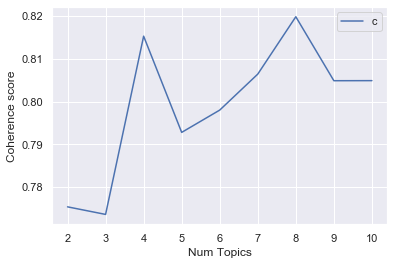

In [25]:
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print(num_topics)
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word,
                                                random_seed=1)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

start1 = 2 
limit1 = 11
step1 = 1

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=start1, limit=limit1, step=step1)

x = range(start1, limit1, step1)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

The above code tests for the Coherence Score metrics for LDA Mallet models with number of topics ranging from two (2) to ten (10) with a corresponding visualization. This should run relatively slower compared to other code snippets.

In [26]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.7754
Num Topics = 3  has Coherence Value of 0.7736
Num Topics = 4  has Coherence Value of 0.8153
Num Topics = 5  has Coherence Value of 0.7928
Num Topics = 6  has Coherence Value of 0.798
Num Topics = 7  has Coherence Value of 0.8064
Num Topics = 8  has Coherence Value of 0.8198
Num Topics = 9  has Coherence Value of 0.8049
Num Topics = 10  has Coherence Value of 0.8049


The Coherence Scores of the nine (9) LDA Models are also displayed above. In this LDA Model case, 8 topics are optimal. 

In [27]:
optimal_model = model_list[6] # Number of Topics = 8

model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.184*"informative" + 0.158*"past" + 0.105*"era" + 0.079*"time" + '
  '0.079*"gem" + 0.053*"view" + 0.026*"tale" + 0.026*"derg" + 0.026*"cover" + '
  '0.026*"raw"'),
 (1,
  '0.111*"hard" + 0.089*"important" + 0.067*"presentation" + 0.044*"tough" + '
  '0.044*"depressing" + 0.044*"building" + 0.044*"shape" + 0.044*"period" + '
  '0.044*"small" + 0.022*"lighting"'),
 (2,
  '0.115*"reminder" + 0.096*"bit" + 0.077*"chill" + 0.058*"display" + '
  '0.038*"lonely" + 0.019*"historical" + 0.019*"move" + 0.019*"organize" + '
  '0.019*"real" + 0.019*"chilling"'),
 (3,
  '0.169*"dark" + 0.051*"average" + 0.051*"recent" + 0.051*"difficult" + '
  '0.034*"guide" + 0.034*"curate" + 0.017*"monument" + 0.017*"preserve" + '
  '0.017*"ministerial" + 0.017*"expo"'),
 (4,
  '0.320*"small" + 0.080*"time" + 0.040*"regime" + 0.040*"hide" + '
  '0.040*"forget" + 0.020*"ancestor" + 0.020*"testament" + 0.020*"evidence" + '
  '0.020*"intense" + 0.020*"background"'),
 (5,
  '0.564*"history" + 0.091*"worth" 

Printing the key words that make up the eight (8) acquired topics

In [35]:
# Convert LDA Mallet to normal LDA since pyLDAvis only takes the latter for visualization
optimal_model2 = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(optimal_model)

# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model2, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.187398  0.013531       1        1  12.625864
2     -0.112698 -0.149167       2        1  12.567699
5     -0.219014  0.108687       3        1  12.557353
4      0.232764  0.238598       4        1  12.503033
6      0.082997 -0.207558       5        1  12.488674
7     -0.020609 -0.238628       6        1  12.476454
1     -0.095812  0.261554       7        1  12.402060
0      0.319770 -0.027017       8        1  12.378862, topic_info=    Category       Freq            Term      Total  loglift  logprob
28   Default  36.000000         history  36.000000  30.0000  30.0000
44   Default  22.000000           small  22.000000  29.0000  29.0000
63   Default  11.000000     informative  11.000000  28.0000  28.0000
55   Default  10.000000            dark  10.000000  27.0000  27.0000
38   Default  10.000000     information  10.000000  26.0000  26.0000
48   Default   9.000000            past   9.000000  25.0000  25.0000
2    Default   8.000000          poorly   8.000000  24.0000  24.0000
23   Default   7.000000           learn   7.000000  23.0000  23.0000
57   Default   7.000000        reminder   7.000000  22.0000  22.0000
89   Default   9.000000            time   9.000000  21.0000  21.0000
60   Default   6.000000             era   6.000000  20.0000  20.0000
50   Default   7.000000            hard   7.000000  19.0000  19.0000
12   Default   5.000000             bit   5.000000  18.0000  18.0000
36   Default   5.000000           worth   5.000000  17.0000  17.0000
68   Default   5.000000       important   5.000000  16.0000  16.0000
85   Default   4.000000             gem   4.000000  15.0000  15.0000
34   Default   4.000000           chill   4.000000  14.0000  14.0000
4    Default   4.000000    presentation   4.000000  13.0000  13.0000
46   Default   3.000000           close   3.000000  12.0000  12.0000
79   Default   3.000000         chapter   3.000000  11.0000  11.0000
1    Default   3.000000         display   3.000000  10.0000  10.0000
215  Default   3.000000            view   3.000000   9.0000   9.0000
59   Default   3.000000       difficult   3.000000   8.0000   8.0000
94   Default   3.000000         average   3.000000   7.0000   7.0000
56   Default   3.000000          recent   3.000000   6.0000   6.0000
72   Default   2.000000          period   2.000000   5.0000   5.0000
37   Default   2.000000        building   2.000000   4.0000   4.0000
76   Default   2.000000      depressing   2.000000   3.0000   3.0000
29   Default   2.000000           shape   2.000000   2.0000   2.0000
244  Default   2.000000           tough   2.000000   1.0000   1.0000
..       ...        ...             ...        ...      ...      ...
63    Topic8  11.173552     informative  11.173552   2.0892  -1.6917
60    Topic8   6.384887             era   6.384887   2.0892  -2.2513
48    Topic8   9.577330            past   9.577330   2.0892  -1.8458
41    Topic8   1.596222            bore   1.596222   2.0892  -3.6376
5     Topic8   1.596222           stuff   2.780486   1.5342  -3.6376
139   Topic8   1.596222         exhibit   2.845089   1.5112  -3.6376
86    Topic8   1.596222             raw   2.896958   1.4932  -3.6376
89    Topic8   4.788665            time   9.689854   1.3844  -2.5390
0     Topic8   0.000000            read   1.350447     -inf     -inf
1     Topic8   0.000000         display   3.552792     -inf     -inf
2     Topic8   0.000000          poorly   8.742072     -inf     -inf
3     Topic8   0.000000        interste   1.184264     -inf     -inf
4     Topic8   0.000000    presentation   4.051340     -inf     -inf
6     Topic8   0.000000         visited   1.300737     -inf     -inf
7     Topic8   0.000000       captivate   1.048589     -inf     -inf
8     Topic8   0.000000            keep   0.000000      NaN     -inf
9     Topic8   0.000000            much   0.000000      NaN     -inf
10    Topic8   0.000000        proba

pyLDAvis allows visualization for topic modelling as seen from the above code. We did not decide to include this in the final presentation as there is too much data to be compressed in a slide.

In [29]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.1422,"hard, important, presentation, tough, depressi...",Sorry no - read the Bradt Guide
1,1,2.0,0.1394,"reminder, bit, chill, display, lonely, histori...",Dusty and poorly displayed
2,2,2.0,0.1410,"reminder, bit, chill, display, lonely, histori...","Intersting stuff, but poor presentation"
3,3,7.0,0.1422,"information, close, chapter, understand, reali...",Shocking but must be visited!
4,4,3.0,0.1400,"dark, average, recent, difficult, guide, curat...",Captivating and shocking
5,5,0.0,0.1250,"informative, past, era, time, gem, view, tale,...","Probably a must see, but not much to keep you ..."
6,6,0.0,0.1394,"informative, past, era, time, gem, view, tale,...",Grace gone a bit down.
7,7,2.0,0.1692,"reminder, bit, chill, display, lonely, histori...",Home to Lucy but overcrowded with Children and...
8,8,0.0,0.1250,"informative, past, era, time, gem, view, tale,...",Hardly world class
9,9,0.0,0.1250,"informative, past, era, time, gem, view, tale,...",Disappointing


The above code assigns all concerned Text with their corresponding topic.

In [30]:
df_dominant_topic['Dominant_Topic'].value_counts()

0.0    92
3.0    27
1.0    26
5.0    22
4.0    21
7.0    21
6.0    20
2.0    20
Name: Dominant_Topic, dtype: int64

In [31]:
df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 0]['Text'].values # Lack of Content - 92
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 1]['Text'].values # Expressing Sadness over History - 26
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 2]['Text'].values # Museum Curation Criticism - 20
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 3]['Text'].values # Expressing Sadness over History - 27
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 4]['Text'].values # Expressing Sadness over History - 21
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 5]['Text'].values # Museum Curation Criticism - 22
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 6]['Text'].values # Museum Curation Criticism - 20
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 7]['Text'].values # Accessibility Criticism - 21

array(['Probably a must see, but not much to keep you there',
       'Grace gone a bit down.', 'Hardly world class', 'Disappointing',
       'Visited the National Museum with Secret Island Ethiopia Tours',
       'Chilling museum of a forgotten horror', 'Average Museum',
       'very boring', 'Interesting but a Little Disappointing',
       'Disappointed', 'Looking pretty tired',
       'Its a summary of Ethiopias harrowing past',
       'A harrowing if brief window on a difficult era for Ethiopia.',
       'Sad and informative',
       'Learn historical information about Ethiopia’s past.',
       'So sad, but something we need to know about',
       'Scary and sadden place to visit', 'A raw gem',
       'Request a guide if you know little about the Dergs', 'Gruesome',
       'Somewhat of a disappointment', 'Not much to see here',
       'Sad thought.', 'Seriously, not good',
       'SAD REFECECTION OF MANS INHUMANITY TO MAN', 'Disappointing',
       'Disappointing', 'Disappointing', '

The above code is the main evaluation part where each topic is assessed if it fits to an identifiable concept. You can interchange the found concepts with their corresponding topic number in the previous dataframe should you want the text to be already tagged with its topic concept. Of course, you can change the concepts found above should you find other identifiable ones.
<br>
<br>The full breakdown and analysis of the six (6) LDA Models for both Ethiopia and Kenya can be found here: 
<br>https://docs.google.com/spreadsheets/d/1QNwNS0qlDuJVTPZvwZiHFJX0_qMma_RER7AVe1lmWlo/edit?usp=sharing
<br>
<br>The notebooks for the six (6) LDA Models for both Ethiopia and Kenya are of the following format (in the EDA + Modelling folder):
<li>Ethiopia - "Ethiopia EDA + Model 4.x.2... .ipynb" where x is from one (1) to six (6)</li>
<li>Kenya - "Kenya EDA + Model 4.x.2... .ipynb" where x is from one (1) to six (6)</li>
<br>There are also saved csv files containing the texts with their corresponding topics (though they are still numbered). The csv files for the six (6) LDA Models for both Ethiopia and Kenya are of the following format (in the EDA + Modelling folder):
<li>Ethiopia - "ethiopia_4x2.csv" where x is from one (1) to six (6)</li>
<li>Kenya - "kenya_4x2.csv" where x is from one (1) to six (6)</li>

<br>You can change the topics within the csv files from numbers to concepts accordingly using the notebooks for the LDA models. 

In [32]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.1557,"informative, past, era, time, gem, view, tale,...",Old Bones and views of the past
1,1.0,0.1428,"hard, important, presentation, tough, depressi...","Bad displays, fragmentary information that doe..."
2,2.0,0.1692,"reminder, bit, chill, display, lonely, histori...",Home to Lucy but overcrowded with Children and...
3,3.0,0.1587,"dark, average, recent, difficult, guide, curat...",A Dark Past which is Recent
4,4.0,0.1528,"small, time, regime, hide, forget, ancestor, t...",It is horrible reminder of the bloody regime o...
5,5.0,0.1587,"history, worth, topic, hidden, bone, city, acc...",Terrifying history
6,6.0,0.1557,"poorly, learn, closed, selam, nonetheless, rim...","Visit Lucy and Selam, but everything else is p..."
7,7.0,0.1587,"information, close, chapter, understand, reali...",Dont understand the bad reviews


The above code creates a dataframe which shows the texts that are the main contributors for the eight (8) acquired topics.

In [33]:
sent_topics_sorteddf_mallet['Text'].values

array(['Old Bones and views of the past',
       'Bad displays, fragmentary information that does not exceed our middle school education ',
       'Home to Lucy but overcrowded with Children and poor displays',
       'A Dark Past which is Recent',
       'It is horrible reminder of the bloody regime of the Derge regime',
       'Terrifying history',
       'Visit Lucy and Selam, but everything else is poorly organized',
       'Dont understand the bad reviews'], dtype=object)